#  1. 수어번역기 모델링 및 추적(개인)

## 1.환경준비

### (1) 라이브러리 로딩

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

import mlflow
import mlflow.keras

In [3]:
np.set_printoptions(linewidth=np.inf)

* 함수 만들기

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

#### 1) 데이터 가져오기
* 제공 받은 데이터를 여러분의 구글드라이브 적절한 위치에 업로드 합니다.
    * 가능하면, 구글드라이브 첫 경로 밑에 폴더를 만들고 업로드 하기를 권장합니다.

In [5]:
path = 'data/'
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [6]:
data.shape

(8000, 785)

#### 2) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [7]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

### (3) mlflow 추적 준비


In [8]:
mlflow_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(mlflow_uri)

### (4) 새 실험 생성
* exp4

In [9]:
exp_id = mlflow.create_experiment("exp4")
exp_id

'2'

## 2 데이터 살펴보기

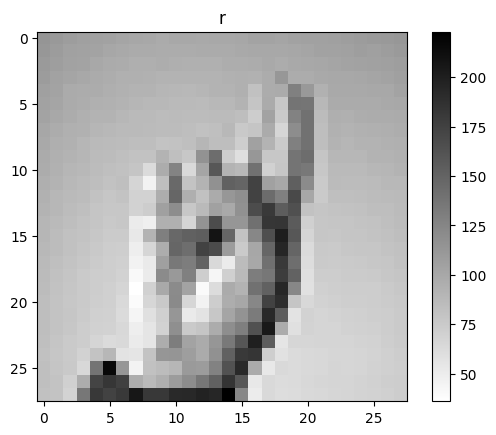

In [10]:
# 아래 숫자를 바꿔가며 화면에 그려 봅시다.
n = 100
sign_fig = data.iloc[n, 1:].values
sign_fig = sign_fig.reshape(28, 28)

sign = class_names[data.iloc[n,0]]

plt.title(sign)
plt.imshow(255-sign_fig, cmap=plt.cm.binary)
plt.colorbar()
plt.show()

## 3.데이터 준비

* 주어진 데이터셋
    * 2차원 데이터셋, 1차원 데이터포인트(분석단위, 예측단위) 입니다. 
    * 흑백 이미지데이터
    * 이 데이터로부터 데이터 준비작업을 수행합니다.
        * 데이터 분할1 : x, y
        * 데이터 분할2 : train, validation
        * 만약 CNN으로 모델링을 한다면, shape를 맞춰야 합니다. (n, 28, 28, 1) 
        * scaling
* 그러나 운영에서 발생될 데이터는 이미지 한장 한장 입니다. 이미지 한장, 한장 들어온다면 어떻게 데이터가 처리되어야 할까요?(Data Pipeline 구성)

### (1) 데이터 분할1 : x, y 나누기

In [12]:
X = data.iloc[:, 1:].values  # 이미지 데이터
y = data.iloc[:, 0].values   # 클래스 레이블

### (2) 데이터 분할2 : train, validation, test

* train : val : test = 5000 : 2000 : 1000
* 여기서 test set은 파이프라인 점검을 위한 용도로 사용합니다.

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3333, random_state=42)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 5600 samples
Validation set: 1600 samples
Test set: 800 samples


### (3) DL을 위한 전처리
* 모두 넘파이로 변환

In [14]:
# 모두 넘파이로 변환

X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.int32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.int32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int32)

* shape 맞추기 n, 28,28,1
    * reshape
        * x_train.shape : (-1, 28, 28, 1)
        * x_val.shape : (-1, 28, 28, 1)
        * x_test.shape : (-1, 28, 28, 1)

In [15]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [16]:
print(f"x_train.shape: {X_train.shape}")
print(f"x_val.shape: {X_val.shape}")
print(f"x_test.shape: {X_test.shape}")

x_train.shape: (5600, 28, 28, 1)
x_val.shape: (1600, 28, 28, 1)
x_test.shape: (800, 28, 28, 1)


* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train2, x_val2 를 그냥 255로 나누면 됨

In [17]:
X_train_scaled = X_train / 255.0
X_val_scaled = X_val / 255.0

## 4.모델링

### (1) 모델1

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

* 학습곡선

In [19]:
history = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_val_scaled, y_val))


Epoch 1/10
175/175 [==============================] - 3s 12ms/step - loss: 2.7992 - accuracy: 0.1538 - val_loss: 1.9833 - val_accuracy: 0.3819
Epoch 2/10
175/175 [==============================] - 2s 11ms/step - loss: 1.4760 - accuracy: 0.5416 - val_loss: 1.1405 - val_accuracy: 0.6463
Epoch 3/10
175/175 [==============================] - 2s 11ms/step - loss: 0.7993 - accuracy: 0.7598 - val_loss: 0.5678 - val_accuracy: 0.8375
Epoch 4/10
175/175 [==============================] - 2s 12ms/step - loss: 0.4749 - accuracy: 0.8523 - val_loss: 0.4150 - val_accuracy: 0.8750
Epoch 5/10
175/175 [==============================] - 2s 12ms/step - loss: 0.3066 - accuracy: 0.9014 - val_loss: 0.2877 - val_accuracy: 0.8988
Epoch 6/10
175/175 [==============================] - 2s 13ms/step - loss: 0.1901 - accuracy: 0.9439 - val_loss: 0.1782 - val_accuracy: 0.9525
Epoch 7/10
175/175 [==============================] - 2s 13ms/step - loss: 0.1225 - accuracy: 0.9639 - val_loss: 0.1243 - val_accuracy: 0.9644

* 예측 및 검증

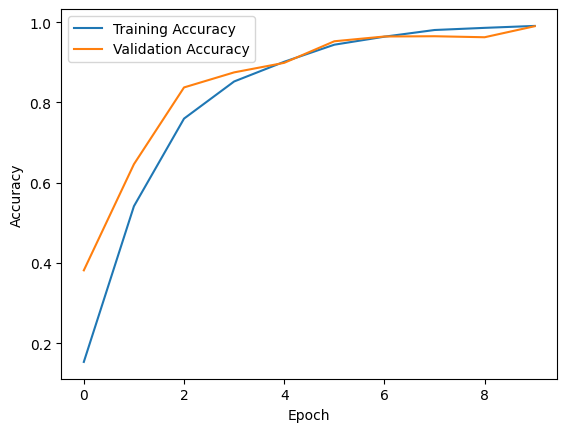

In [20]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

(None, 28, 28, 1)
X_test_scaled Shape: (800, 28, 28, 1)
Model Input Shape after Reshaping: (None, 28, 28, 1)
25/25 [==============================] - 0s 4ms/step - loss: 35.8460 - accuracy: 0.9050
Test Accuracy: 0.9049999713897705
25/25 [==============================] - 0s 3ms/step


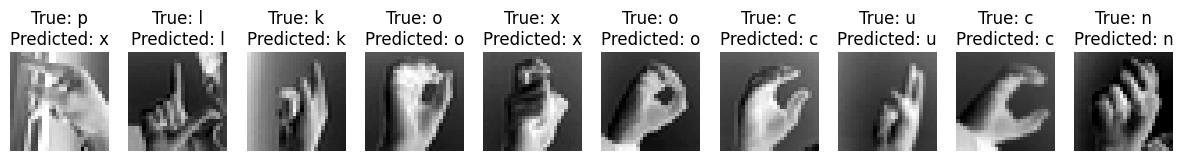

In [22]:
print(model.input_shape)
print("X_test_scaled Shape:", X_test.shape)

X_test_scaled_4D = X_test.reshape(-1, 28, 28, 1)

print("Model Input Shape after Reshaping:", model.input_shape)

test_loss, test_acc = model.evaluate(X_test_scaled_4D, y_test)
print(f"Test Accuracy: {test_acc}")

predictions = model.predict(X_test_scaled_4D)
predicted_labels = np.argmax(predictions, axis=1)

n = 10  
plt.figure(figsize=(15, 3))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.title(f"True: {class_names[y_test[i]]}\nPredicted: {class_names[predicted_labels[i]]}")
    plt.axis('off')
plt.show()


### (2) 모델2

* 학습곡선

* 예측 및 검증

## 5.모델 사용하기
* 가장 성능이 좋은 모델 production 지정
* Production 모델 호출해서 test 셋으로 예측 및 평가



In [24]:
model_uri = 'models:/Sign_Signal/production'
model_p = mlflow.keras.load_model(model_uri)

In [ ]:
pred = model_p.predict(x_test)
pred_1 = pred.argmax(axis=1)